In [1]:
import tqdm.notebook as tq
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor,LinearRegression, Lasso
from sklearn.feature_selection import f_regression,chi2,SelectKBest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
import torch
from torch import nn
import matplotlib.pyplot as plt
import xgboost as xg

# Load the dataset

In [3]:
df_train = pd.read_csv('train.csv', dtype={'author': np.int64, 'hindex': np.float32})
df_test = pd.read_csv('test.csv', dtype={'author': np.int64})
x_train_complete = pd.read_csv('X_train.csv')
y_train_complete = pd.read_csv('y_train.csv')
x_test_complete = pd.read_csv('X_test.csv')

x_train,x_val,y_train,y_val = train_test_split(x_train_complete,y_train_complete)
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()
x_train = np.nan_to_num(x_train)
x_val = np.nan_to_num(x_val)

In [4]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

### Tools

In [5]:
def fit_test(reg,x_train,y_train,x_test,y_test):
    print("Fitting")
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test) 
    y_pred[y_pred < 0] = 1 #minimum h index is 1
    mse = mean_squared_error(y_test, y_pred)
    print(f"Loss: {mse}")
    
def save_to_submit(reg,x_test,filename='submission.csv'):
    y_pred = reg.predict(x_test)
    y_pred[y_pred < 1] = 1
    # write the predictions to file
    df_test['hindex'] = pd.Series(np.round_(y_pred, decimals=3))
    df_test.loc[:,["author","hindex"]].to_csv(filename, index=False)
    
def reduction(k,x_train,y_train,x_test,method):
    methods = ["pca","chi2","f_regression"]
    if method == "pca":
        transformation = PCA(n_components=k)
        transformation.fit(x_train)
    elif method == "chi2":
        transformation = SelectKBest(chi2, k=k)
        transformation.fit(x_train,y_train)
    elif method == "f_regression":
        transformation = SelectKBest(f_regression, k=k)
        transformation.fit(x_train,y_train)
    else:
        print("Please choose a reduction method among:"+" ".join(methods))
        return None,None
    return transformation.transform(x_train),transformation.transform(x_test)

# Comparing different methods

### Sklearn regressors

#### Linear regressor

In [6]:
linearreg = LinearRegression()
fit_test(linearreg,x_train,y_train,x_val,y_val)

Fitting
Loss: 61.65964020840836


In [7]:
lassoreg = Lasso(max_iter = 2000)
fit_test(lassoreg,x_train,y_train,x_val,y_val)

Fitting
Loss: 77.71858134590435


#### KNN regressor

In [8]:
K = np.arange(12,18)
MSE = np.zeros(len(K))

#We try for various k
for i in tqdm(range(len(K))):
    k = K[i]
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(x_train, y_train)
    y_pred = knnreg.predict(x_val) 
    y_pred[y_pred < 0] = 1 #minimum h index is 1
    mse = mean_squared_error(y_val, y_pred)
    MSE[i] = mse

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [33:01<00:00, 330.30s/it]


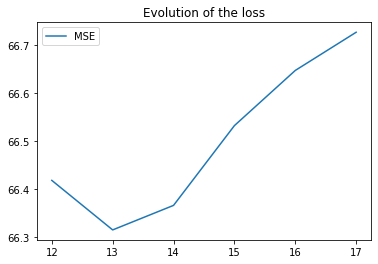

In [10]:
plt.title("Evolution of the loss")
plt.plot(K, MSE, label = 'MSE')
plt.legend(loc = 'best')
plt.show()

#### Naive Bayes

In [8]:
nbreg = GaussianNB()
fit_test(nbreg,x_train,y_train,x_val,y_val)

Fitting
Loss: 181.66515920203852


#### Decision Tree

In [9]:
dtreg = tree.DecisionTreeRegressor()
fit_test(dtreg,x_train,y_train,x_val,y_val)

Fitting
Loss: 122.34739790179289


In [22]:
rdreg = RandomForestRegressor(n_estimators = 10)
fit_test(rdreg,x_train,y_train,x_val,y_val)

Fitting
Loss: 60.79605013659006


#### Gradient Boosting

In [23]:
lgbmreg = LGBMRegressor(objective='mse',
                    boosting_type='dart',
                    colsample_bytree=1,
                    learning_rate=0.1,
                    max_depth=10,
                    n_estimators=1000,
                    num_leaves=32,
                    reg_alpha=0.5,
                    reg_lambda=1,
                    subsample=0.5,
                    n_jobs=12)
# x_train_red,x_val_red = reduction(32,x_train,y_train,x_val,"pca")
fit_test(lgbmreg,x_train,y_train,x_val,y_val)

Fitting
Loss: 49.15352643757912


In [ ]:
adareg = AdaBoostRegressor(random_state=0, n_estimators=100)
fit_test(adareg,x_train,y_train,x_val,y_val)

Fitting


In [ ]:
sgdreg = SGDRegressor(max_iter=5000, tol=1e-3,shuffle=True)
fit_test(adareg,x_train,y_train,x_val,y_val)

### Neural Network

In [11]:
X = torch.from_numpy(x_train).float()
X_t = torch.from_numpy(x_val).float()
y_tr = torch.from_numpy(y_train).float().reshape(-1,1)
y_t = torch.from_numpy(y_val).float().reshape(-1,1)

In [13]:
# #Architecture
# model = nn.Sequential(
#           nn.Linear(x_train.shape[1],128,bias=True),
#           nn.Dropout(p=0.5),
#           nn.Tanh(),
#           nn.Linear(128,64,bias=True),
#           nn.Sigmoid(),
#           nn.Linear(64,1,bias=True),
#           nn.ReLU())

# #Architecture
# model = nn.Sequential(
#           nn.Linear(x_train.shape[1],256,bias=True),
#           nn.Tanh(),
#           nn.Linear(256,64,bias=True),
#           nn.Sigmoid(),
#           nn.Linear(64,16,bias=True),
#           nn.ReLU(),
#           nn.Linear(16,1,bias=True),
#           nn.ReLU())

#Architecture
#model = nn.Sequential(
#         nn.Linear(x_train.shape[1],128,bias=True),
#         nn.Tanh(),
#         nn.Linear(128,64,bias=True),
#         nn.Sigmoid(),
#         nn.Linear(64,32,bias=True),
#         nn.ReLU(),
#         nn.Linear(32,1,bias=True),
#         nn.ReLU())

#Architecture
model = nn.Sequential(
          nn.Linear(x_train.shape[1],64,bias=True),
          nn.Tanh(),
          nn.Linear(64,1,bias=True),
          nn.ReLU())

loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(),amsgrad=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

#init performance measures
tr_acc = []
test_acc = []

for epoch in tq.tqdm(range(1000)):
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    output= model.forward(X)
    loss = loss_function(output, y_tr)
    
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    #update loss and accuracy
    if epoch%100==0:
        print("epoch",epoch,"---------------------------")
        with torch.no_grad():
            output_te=model.forward(X_t)
            loss_test = loss_function(output_te, y_t)
            tr_acc.append(loss.data.item())
            test_acc.append(loss_test.data.item())
            print("test loss:",loss_test.data.item())
            print("train loss:",loss.data.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0 ---------------------------
test loss: 257.7081604003906
train loss: 257.71771240234375
epoch 100 ---------------------------
test loss: 142.7319793701172
train loss: 142.06304931640625
epoch 200 ---------------------------
test loss: 112.92045593261719
train loss: 112.3491439819336
epoch 300 ---------------------------
test loss: 96.19949340820312
train loss: 95.70307922363281
epoch 400 ---------------------------
test loss: 84.94175720214844
train loss: 84.19196319580078
epoch 500 ---------------------------
test loss: 76.62013244628906
train loss: 75.4260482788086
epoch 600 ---------------------------
test loss: 70.80780029296875
train loss: 68.89713287353516
epoch 700 ---------------------------
test loss: 66.82489776611328
train loss: 64.07988739013672
epoch 800 ---------------------------
test loss: 63.92000961303711
train loss: 60.28025436401367
epoch 900 ---------------------------
test loss: 61.715087890625
train loss: 57.127159118652344


In [21]:
optimizer.zero_grad() #required since pytorch accumulates the gradients
output= model.forward(X)
loss = loss_function(output, y_tr)
print("Loss : ", loss)

Loss :  tensor(54.4561, grad_fn=<MseLossBackward0>)


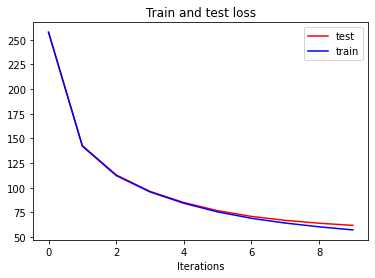

In [14]:
plt.plot(test_acc, c='r', label='test')
plt.plot(tr_acc, c='b', label='train')
plt.title("Train and test loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()